In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

DEBUG = True # verbose printout when running rule text generator

In [8]:
img_folder = '../../experiment/images/'
stims = ['stim00',
        'stim01',
        'stim02',
        'stim03',
        'stim04',
        'stim05',
        'stim06',
        'stim07'
        ]

## code copy-pasted from ruletext_generator.py

and then i added print statements for verbosity/debugging ease

In [9]:
# Problem types
def typeI(stim):
    return stim % 2
def typeII(stim):
    labels = [0,1,1,0,0,1,1,0]
    return(labels[stim])
def typeIII(stim):
    labels = [1,0,1,0,1,1,0,0]
    return(labels[stim])
def typeIV(stim):
    labels = [1,1,1,0,1,0,0,0]
    return(labels[stim])
def typeV(stim):
    labels = [1,0,1,0,1,0,0,1]
    return(labels[stim])
def typeVI(stim):
    labels = [1,0,0,1,0,1,1,0]
    return(labels[stim])

catfuns = [typeI, typeII, typeIII, typeIV, typeV, typeVI]

In [10]:
# SHJ counterbalancing tools as written in javascript by crump/mcdonnell/gureckis and translated to python by me pam

# 0 <= dimorder < 6, which order to order the dimensions
# 0 <= dimvals < 8, whether a '0' means 0 or 1 in terms of the stim.

# // We want to be able to alias the order of stimuli to a single number which
# // can be stored and which can easily replicate a given stimulus order.
# /* Extra details: arr is 3 digits which together would be the binary version of decimal number 0 thru 7.
#    E.g., arr = [0,1,0] is binary for decimal 2.
#    Ordernum is either 0 or 1. << WRONG i think it's between 0 and 5 inclusive
# */
def changeorder(arr, ordernum):
    thisorder = ordernum
    shufflelocations = []
    
    for i in range(len(arr)):
        shufflelocations.append(i); # Now shufflelocations = [0,1,2]
    
    for i in reversed(range(len(arr))): # i=2,1,0
        loci = shufflelocations[i]
        locj = shufflelocations[int(thisorder%(i+1))] # [0, 1] modulo [3, 2, 1]
        # Note that 0 mod anything is 0
        # whereas 1%3=1, 1%2=1, 1%1=0
        thisorder = np.floor(thisorder/(i+1)) # for i=2,1,0 then thisorder=0,0,1 for ordernum=1, and 0,0,0 otherwise
        tempi = arr[loci]
        tempj = arr[locj]
        arr[loci] = tempj
        arr[locj] = tempi
    
    return arr

# // Stimulus counterbalancer
def getstim(theorystim,condition):
    assert theorystim < 8, "Stim >=8 ("+theorystim+")"
    assert theorystim >= 0, "Stim less than 0 ("+theorystim+")"
    flippedstim = theorystim^condition['dimvals'] # Here the stim identities are flipped
#         /* Carrot ^ is bitwise XOR operator. 
#         */

    bits = []
    for i in range(3):
        if flippedstim&(2**i): # if this is nonzero
            bits.append(1)
        else:
            bits.append(0)
#         /* Ampersand & is bitwise AND operator.
#         */

    newbits = changeorder(bits, condition['dimorder']) # in javascript, no new var here bc function works in-place

    multiples = [1, 2, 4]
    ret = 0
    for i in range(3):
        ret += multiples[i] * newbits[i]; # Here we convert from binary [bits] to decimal
    
    return ret

In [54]:
def ruleToText(rule, dimorder, dimvals):
    condition={"dimorder":dimorder,
                "dimvals":dimvals}

    catfun=catfuns[rule]
    stims = ['stim00',
        'stim01',
        'stim02',
        'stim03',
        'stim04',
        'stim05',
        'stim06',
        'stim07'
        ]
    allstims = [0,1,2,3,4,5,6,7]

    groupBool = [catfun(a) for a in range(8)]
    groupLabel=[]
    for ii in groupBool:
        if ii:
            groupLabel.append("B")
        else:
            groupLabel.append("A")

    stimcardspresented = []

    for ii in range(len(allstims)):
        prescard = allstims[ii]
        stim = stims[getstim(prescard,condition)]
        stimcardspresented.append(stim)
        if DEBUG:
            img = mpimg.imread(img_folder+stim+".png")
            plt.subplot(1,8,ii+1,title=catfun(prescard))
            plt.imshow(img)  
            
    #new march 21 2022
    label_code = {"size": ['large', 'small'],
                 "color": ['black','white'],
                 "shape": ['square','triangle']}

    labeled_stims = {"stim00": ['large','black','square'],
                 "stim01": ['large','white','square'],
                 "stim02": ['large','black','triangle'],
                 "stim03": ['large','white','triangle'],
                 "stim04": ['small','black','square'],
                 "stim05": ['small','white','square'],
                 "stim06": ['small','black','triangle'],
                 "stim07": ['small','white','triangle']
                }
    ruletext_templates = ['{feat1} cards are in Group A. {feat1inv} cards are in Group B.',
            '{feat1} {feat2} and {feat1inv} {feat2inv} cards are in Group A. {feat1} {feat2inv} and {feat1inv} {feat2} cards are in Group B.',
            '{feat1} cards are in Group A except for the {feat1exception} card. {feat1inv} cards are in Group B except for the {feat1invexception} card.',
            '{feat1} cards are in Group A except for the {feat1exception} card. {feat1inv} cards are in Group B except for the {feat1invexception} card.',
            '{feat1} cards are in Group A except for the {feat1exception} card. {feat1inv} cards are in Group B except for the {feat1invexception} card.',
            'Don\'t even try me yet!'
            ]

    carddata = { "png": stimcardspresented,
        "catBool": groupBool,
        "catLabel": groupLabel,
        "size": [labeled_stims[fname][0] for fname in stimcardspresented],
        "color": [labeled_stims[fname][1] for fname in stimcardspresented],
        "shape": [labeled_stims[fname][2] for fname in stimcardspresented],
        }
    df = pd.DataFrame(carddata)
    aCards = df.query("catLabel=='A'")
    bCards = df.query("catLabel=='B'")

    txt = ""

    if rule==0: # TYPE 1
        feat1=None
        feat1inv=None
        
        # One relevant feature dimension, let's find it
        df_a = aCards[['size','color','shape']]
        relevantDimension = df_a.columns[df_a.nunique() <= 1][0]
        feat1 = df_a.loc[0,relevantDimension]
        
        feat1inv = df[relevantDimension].unique()[df[relevantDimension].unique() != feat1][0]
        txt = ruletext_templates[rule].format(feat1=feat1.capitalize(), feat1inv=feat1inv.capitalize())

    elif rule==1: # TYPE 2
        # find two relevant dimensions
        df_a = pd.DataFrame() #aCards[['size','color','shape']]
        
        if DEBUG:
            print("aCards: ")
            display(aCards)
            
        for col in ['size','color','shape']:
            df_a[col] = aCards[col].astype('category').cat.codes
#             if DEBUG:
#                 print("Setting df_a column "+col+" with: ")
#                 display(aCards[col].astype('category').cat.codes)
                
        correlation = df_a.corr().abs()
        
        if DEBUG:
            print("df_a: ",df_a)
            print("correlation: ",correlation)
        
        relcols = [col for col in correlation.columns if correlation[col].sum()==2]
        
        if DEBUG:
            print("relevant columns: ",relcols)
            print(df_a.groupby(relcols).groups)
        featurepairs = [list(key) for key in df_a.groupby(relcols).groups]
        
        if DEBUG:
            print("feature pairs: ",featurepairs)
            print("aCards.reset_index(): ",aCards.reset_index())
            
        # FIX: use the feature pairs term to get the label of the relevant columns and dimension values
        # first row of feat_pairs is group A, second row is group B features
        # first columne of feat_pairs is the correct feature name for that relevant column (e.g., 0 means large if relcol is size)
        # so we use our label_code dictionary to get the string name of the features for A and B (B=inverse of A) 
#         feat1 = aCards.reset_index().loc[featurepairs[0][0],relcols[0]]
        feat1 = label_code[relcols[0]][featurepairs[0][0]]
        
        if DEBUG:
            print("feat1 = aCards.reset_index().loc[featurepairs[0][0],relcols[0]]")
            print(feat1)
#             print(aCards)
            
#         feat2 = aCards.reset_index().loc[featurepairs[0][1],relcols[1]]
        feat2 = label_code[relcols[1]][featurepairs[0][1]]
        
        if DEBUG:
            print("feat2 = aCards.reset_index().loc[featurepairs[0][1],relcols[1]]")
            print(feat2)
#             print(aCards)
        
        
#         feat1inv = aCards.reset_index().loc[featurepairs[1][0],relcols[0]]
#         feat2inv = aCards.reset_index().loc[featurepairs[1][1],relcols[1]]
        
        feat1inv = label_code[relcols[0]][featurepairs[1][0]]
        feat2inv = label_code[relcols[1]][featurepairs[1][1]]
            
        txt = ruletext_templates[rule].format(feat1=feat1.capitalize(), feat2=feat2, feat1inv=feat1inv, feat2inv=feat2inv)
        if DEBUG:
            print("FINAL RULE TEXT: ",txt)
    elif rule>=2: # TYPE 3
        df_a = aCards[['size','color','shape']]
        relcols=[]
        featvals=[]
        for col in df_a.columns:
            cts = df_a[col].value_counts()
            for row in cts.iteritems():
                r=list(row)
                if r[1]>2:
                    relcols.append(col)
                    featvals.append(r[0])

        # multiple ways to explain the rule so choose one
        rndchoice = np.random.randint(0,len(relcols))
        relevantDimension = relcols[rndchoice]
        feat1 = featvals[rndchoice]
        feat1inv = df[relevantDimension].unique()[df[relevantDimension].unique() != feat1][0]

        # find row of B where relevantDimension==feat1
        df_b = bCards[['size','color','shape']]
        feat1exception = ", ".join(df_b[df_b[relevantDimension]==feat1].values[0])
        # find row of A where relevantDimension==feat1inv
        feat1invexception = ", ".join(df_a[df_a[relevantDimension]==feat1inv].values[0])
        
        txt = ruletext_templates[rule].format(feat1=feat1.capitalize(), feat1exception=feat1exception, feat1inv=feat1inv.capitalize(), feat1invexception=feat1invexception)
    elif rule>=5 | rule<0:
        print("no way jose, rule needs to be 0,1,2,3,4")

    return txt

## testing the code 

since DEBUG=True at the top of the page, the code will print out lots of info for rule type II 

pam's TESTING shows that dimorder can be varied (while dimvals kept constant) and text will generate correctly.
however, when dimvals is 1,2,5,6 we see incorrect rules

pam fixed the code since the problem appeared to be using the string numerical codes (0 or 1 for large or small) as indexes.

aCards: 


,png,catBool,catLabel,size,color,shape
0,stim04,0,A,small,black,square
3,stim01,0,A,large,white,square
4,stim06,0,A,small,black,triangle
7,stim03,0,A,large,white,triangle


df_a:     size  color  shape
0     1      0      0
3     0      1      0
4     1      0      1
7     0      1      1
correlation:                 size         color         shape
size   1.000000e+00  1.000000e+00  5.551115e-17
color  1.000000e+00  1.000000e+00  5.551115e-17
shape  5.551115e-17  5.551115e-17  1.000000e+00
relevant columns:  ['size', 'color']
{(0, 1): [3, 7], (1, 0): [0, 4]}
feature pairs:  [[0, 1], [1, 0]]
aCards.reset_index():     index     png  catBool catLabel   size  color     shape
0      0  stim04        0        A  small  black    square
1      3  stim01        0        A  large  white    square
2      4  stim06        0        A  small  black  triangle
3      7  stim03        0        A  large  white  triangle
feat1 = aCards.reset_index().loc[featurepairs[0][0],relcols[0]]
large
feat2 = aCards.reset_index().loc[featurepairs[0][1],relcols[1]]
white
FINAL RULE TEXT:  Large white and small black cards are in Group A. Large black and small white cards are in Group B

'Large white and small black cards are in Group A. Large black and small white cards are in Group B.'

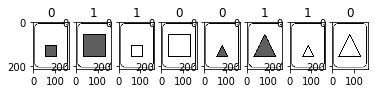

In [55]:
# test different dimorders and dimvals to see where it messes up

rule = 1 # zero indexed rule type II
dimorder = 0 # 0 <= dimorder < 6, which order to order the dimensions
dimvals = 1 # 0 <= dimvals < 8, whether a '0' means 0 or 1 in terms of the stim.

ruleToText(rule, dimorder, dimvals)